# Pre-Requesite

In [2]:
!git clone https://github.com/cl3m3nt/resnet.git

Cloning into 'resnet'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 28 (delta 8), reused 28 (delta 8), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [3]:
!git clone https://github.com/keras-team/keras-applications.git
# move keras_applications at same level than keras-applications
# otherwise next import will fail

Cloning into 'keras-applications'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 482 (delta 2), reused 3 (delta 0), pack-reused 474
Receiving objects: 100% (482/482), 462.55 KiB | 18.50 MiB/s, done.
Resolving deltas: 100% (340/340), done.


In [4]:
!nvidia-smi

Tue Nov  3 13:11:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Resnet18 Architecture

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import ZeroPadding2D, Input, GlobalAveragePooling2D,GlobalMaxPooling2D,Dense
from tensorflow.keras.layers import Convolution2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.layers import Activation,Dropout,Flatten
from tensorflow.keras.models import Model,Sequential
from keras_applications.imagenet_utils import _obtain_input_shape, get_submodules_from_kwargs
import os
import cv2
import numpy as np
import tensorflow.keras.datasets as datasets
import tensorflow_datasets as tfds

In [6]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3

    else: 
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block +'_branch'

    x = Convolution2D(filters1,(1,1),
               kernel_initializer='he_normal',
               name = conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis,name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(filters2, kernel_size,
               padding='same',
               kernel_initializer='he_normal',
               name = conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis,name=bn_name_base+'2b')(x)
    x = Activation('relu')(x)

    x = tf.keras.layers.add([x,input_tensor])
    x = Activation('relu')(x)
    return x


In [7]:
def conv_block(input_tensor,kernel_size,filters,stage,block,strides=(2,2)):

    filters1, filters2 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(filters1,(1,1),strides=strides,
               kernel_initializer='he_normal',
               name = conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(bn_axis,name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)


    x = Convolution2D(filters2, kernel_size,
               padding='same',
               kernel_initializer='he_normal',
               name = conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis,name=bn_name_base+'2b')(x)
    x = Activation('relu')(x)

    
    shortcut = Convolution2D(filters2,(1,1),strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base+'1')(input_tensor)
    
    shortcut = BatchNormalization(
        axis=bn_axis,name=bn_name_base+'1')(shortcut)
    
    x = tf.keras.layers.add([x,shortcut])
    x = Activation('relu')(x)
    return x

In [8]:
backend = tf.compat.v1.keras.backend
layers = tf.keras.layers
models = tf.keras.models
utils = tf.keras.utils

In [77]:
def ResNet18(include_top=True,
             weights='cifar100_coarse',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=20,
             **kwargs):
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)



    if not (weights in {'cifar100_coarse', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `cifar100_coarse` '
                         '(pre-training on cifar100 coarse (super) classes), '
                         'or the path to the weights file to be loaded.')

    if weights == 'cifar100_coarse' and include_top and classes != 20:
        raise ValueError('If using `weights` as `"cifar100_coarse"` with `include_top`'
                         ' as true, `classes` should be 20')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not tf.keras.backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D(padding=(3,3),name='conv1_pad')(img_input)
    x = Convolution2D(64,(7,7),
                      strides=(2,2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = BatchNormalization(axis=bn_axis,name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1),name='pool1_pad')(x)
    x = MaxPooling2D((3,3),strides=(2,2))(x)

    x = identity_block(x,3,[64,64],stage=2,block='a')
    x = identity_block(x,3,[64,64],stage=2,block='b')

    x = conv_block(x,3,[128,128],stage=3,block='a')
    x = identity_block(x,3,[128,128],stage=3,block='b')

    x = conv_block(x,3,[256,256],stage=4,block='a')
    x = identity_block(x,3,[256,256],stage=4,block='b')

    x = conv_block(x,3,[512,512],stage=5,block='a')
    x = identity_block(x,3,[512,512],stage=5,block='b')


    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='fc20')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)
        '''
        else:
            warnings.warn('The output shape of `ResNet18(include_top=False)` '
                          'has been changed since Keras 2.2.0.')
        '''
    

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet18')

    # Load weights.
    if weights == 'cifar100_coarse':
        if include_top:
            weights_path = keras_utils.get_file(
                'resnet18_cifar100_top.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                file_hash='4e364425e6d5ac22dfc34abaaf0a61fbc397b406914d8594494687f38605d710')
        else:
            weights_path = keras_utils.get_file(
                'resnet18_cifar100_no_top.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                file_hash='d7f440ebc0d202f9e49c6625d7b21c638d1d82ba3b630485eed4f29cfd2dee05')
        model.load_weights(weights_path)

  
    return model

In [70]:
!shasum -a 256 resnet18_cifar100_top.h5

4e364425e6d5ac22dfc34abaaf0a61fbc397b406914d8594494687f38605d710  resnet18_cifar100_top.h5


In [71]:
!shasum -a 256 resnet18_cifar100_no_top.h5

d7f440ebc0d202f9e49c6625d7b21c638d1d82ba3b630485eed4f29cfd2dee05  resnet18_cifar100_no_top.h5


In [14]:
def compile(model):
    model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )
    return model

In [15]:
# CIFAR100 coarse from tf.keras.datasets 
cifar100_coarse = datasets.cifar100
(x_train_100_coarse,y_train_100_coarse),(x_test_100_coarse,y_test_100_coarse) = cifar100_coarse.load_data(label_mode="coarse")
x_train_100_coarse = x_train_100_coarse/255.0
x_test_100_coarse = x_test_100_coarse/255.0

In [ ]:
# Resnet18_100_coarse from ResNet18 class with TOP
input_shape = (32,32,3)
my_resnet18 = ResNet18(include_top=True,weights=None,classes=20,input_shape=input_shape,backend=backend,layers=layers,models=models,utils=utils)
my_resnet18 = compile(my_resnet18)
my_resnet18.summary()

In [13]:
# Training ResNet18 with TOP with CIFAR10
history = my_resnet18.fit(x_train_100_coarse,y_train_100_coarse,
                          validation_data = (x_test_100_coarse,y_test_100_coarse),
                          epochs=10
                        )

Epoch 1/10
1563/1563 [==============================] - 23s 15ms/step - loss: 2.3938 - accuracy: 0.2897 - val_loss: 2.2701 - val_accuracy: 0.3224
Epoch 2/10
1563/1563 [==============================] - 23s 14ms/step - loss: 1.9376 - accuracy: 0.4074 - val_loss: 2.8818 - val_accuracy: 0.2946
Epoch 3/10
1563/1563 [==============================] - 23s 14ms/step - loss: 1.7218 - accuracy: 0.4691 - val_loss: 2.0256 - val_accuracy: 0.3976
Epoch 4/10
1563/1563 [==============================] - 23s 14ms/step - loss: 1.5521 - accuracy: 0.5198 - val_loss: 1.6749 - val_accuracy: 0.4838
Epoch 5/10
1563/1563 [==============================] - 23s 14ms/step - loss: 1.3914 - accuracy: 0.5644 - val_loss: 1.9918 - val_accuracy: 0.4245
Epoch 6/10
1563/1563 [==============================] - 23s 14ms/step - loss: 1.2552 - accuracy: 0.6058 - val_loss: 2.2298 - val_accuracy: 0.3905
Epoch 7/10
1563/1563 [==============================] - 23s 14ms/step - loss: 1.1227 - accuracy: 0.6458 - val_loss: 2.6360 -

# Save, Reload Model, Predict

In [16]:
import matplotlib.pyplot as plt

In [17]:
my_resnet18.save_weights("resnet18_cifar100_top.h5")

In [18]:
!ls -lh

total 27M
drwxr-xr-x 3 root root 4.0K Nov  3 13:11 keras_applications
drwxr-xr-x 5 root root 4.0K Nov  3 13:11 keras-applications
drwxr-xr-x 3 root root 4.0K Nov  3 13:11 resnet
-rw-r--r-- 1 root root  27M Nov  3 13:16 resnet18_cifar100_top.h5
drwxr-xr-x 1 root root 4.0K Oct 28 16:30 sample_data


In [ ]:
input_shape = (32,32,3)
loaded_resnet = ResNet18(include_top=True,weights=None,classes=20,input_shape=input_shape,backend=backend,layers=layers,models=models,utils=utils)
loaded_resnet = compile(my_resnet18)
loaded_resnet.load_weights('resnet18_cifar100_top.h5')
loaded_resnet.summary()

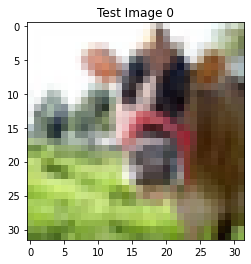

In [20]:
test_images = x_train_100_coarse[:100]
plt.imshow(test_images[0])
plt.title("Test Image 0")
plt.show()

In [21]:
cifar100_supsub_classes={"aquatic": "mammals	beaver, dolphin, otter, seal, whale",
"fish":	"aquarium fish, flatfish, ray, shark, trout",
"flowers":	"orchids, poppies, roses, sunflowers, tulips",
"food containers":	"bottles, bowls, cans, cups, plates",
"fruit and vegetables":	"apples, mushrooms, oranges, pears, sweet peppers",
"household electrical devices":	"clock, computer keyboard, lamp, telephone, television",
"household furniture":	"bed, chair, couch, table, wardrobe",
"insects":	"bee, beetle, butterfly, caterpillar, cockroach",
"large carnivores":	"bear, leopard, lion, tiger, wolf",
"large man-made outdoor things":	"bridge, castle, house, road, skyscraper",
"large natural outdoor scenes":	"cloud, forest, mountain, plain, sea",
"large omnivores and herbivores":	"camel, cattle, chimpanzee, elephant, kangaroo",
"medium-sized mammals":	"fox, porcupine, possum, raccoon, skunk",
"non-insect invertebrates":	"crab, lobster, snail, spider, worm",
"people":	"baby, boy, girl, man, woman",
"reptiles":	"crocodile, dinosaur, lizard, snake, turtle",
"small mammals":	"hamster, mouse, rabbit, shrew, squirrel",
"trees"	:"maple, oak, palm, pine, willow",
"vehicles 1":	"bicycle, bus, motorcycle, pickup truck, train",
"vehicles 2": "lawn-mower, rocket, streetcar, tank, tractor"}
print(cifar100_supsub_classes['fish'])

aquarium fish, flatfish, ray, shark, trout


In [22]:
cifar100_super_classes = {}
i = 0
for key in cifar100_supsub_classes.keys():
  cifar100_super_classes[i]=key
  i=i+1
print(cifar100_super_classes)

{0: 'aquatic', 1: 'fish', 2: 'flowers', 3: 'food containers', 4: 'fruit and vegetables', 5: 'household electrical devices', 6: 'household furniture', 7: 'insects', 8: 'large carnivores', 9: 'large man-made outdoor things', 10: 'large natural outdoor scenes', 11: 'large omnivores and herbivores', 12: 'medium-sized mammals', 13: 'non-insect invertebrates', 14: 'people', 15: 'reptiles', 16: 'small mammals', 17: 'trees', 18: 'vehicles 1', 19: 'vehicles 2'}


In [23]:
predictions = loaded_resnet.predict(test_images)
pred0 = np.argmax(predictions[0])
print(pred0)

11


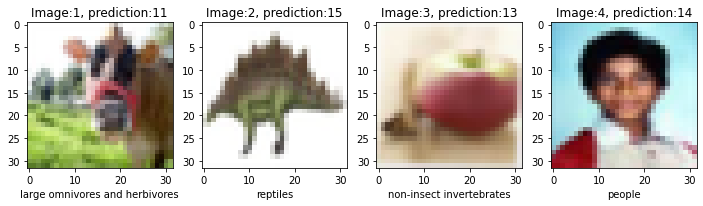

In [24]:
import matplotlib.pyplot as plt
fig =  plt.subplots(figsize=(12,6))
i = 0
j = 1
for i in range(0,1):
  for j in range(1,5):
    plt.subplot(1,4,j)
    plt.imshow(test_images[j-1])
    plt.title(f'Image:{j}, prediction:{np.argmax(predictions[j-1])}')
    plt.xlabel(f'{cifar100_super_classes[np.argmax(predictions[j-1])]}')
    j = j+1
plt.show()

# Neural Network info

In [ ]:
# Layers Info
def nn_layers_info(neural_net):
  print(f'There are {len(neural_net.layers)} layers')
  return neural_net.layers

nn_layers_info(my_resnet18)

In [26]:
# Weights Info
def nn_weights_info(neural_net):
  print(f'There are {len(neural_net.weights)} weights')

nn_weights_info(my_resnet18)

There are 122 weights


In [ ]:
# Params Info
def nn_params_info(neural_net):
  for layer in my_resnet18.layers:
    print(f'layer name:{layer.name}, number of parameters: {layer.count_params()}')
  return f'Total parameters {neural_net.count_params()}'

nn_params_info(my_resnet18)

In [ ]:
# Summary Info
def nn_summary(neural_net):
  return neural_net.summary()

nn_summary(my_resnet18)

# ResNet18 NO TOP Weights

## Cifar100 No Weights

In [ ]:
# Resnet18_100 from ResNet18 class with TOP & no Weigths
input_shape = (32,32,3)
top_resnet18 = ResNet18(include_top=True,weights=None,classes=20,input_shape=input_shape,backend=backend,layers=layers,models=models,utils=utils)
top_resnet18 = compile(top_resnet18)
top_resnet18.summary()

In [ ]:
# Resnet18_100 from ResNet18 class with No TOP & no Weigths
input_shape = (32,32,3)
notop_resnet18 = ResNet18(include_top=False,pooling='avg',weights=None,classes=20,input_shape=input_shape,backend=backend,layers=layers,models=models,utils=utils)
notop_resnet18 = compile(notop_resnet18)
notop_resnet18.summary()

##Cifar100 load Weights

In [ ]:
# Resnet18_100 from ResNet18 class with TOP & Cifar100 Weigths
input_shape = (32,32,3)
top_resnet18 = ResNet18(include_top=True,weights=None,classes=20,input_shape=input_shape,backend=backend,layers=layers,models=models,utils=utils)
top_resnet18 = compile(top_resnet18)
top_resnet18.load_weights('resnet18_cifar100_top.h5')
top_resnet18.summary()

In [ ]:
# Resnet18_100_coarse from ResNet18 class with NO TOP & Cifar100 notop Weights
new_input = top_resnet18.input
hidden_layers = top_resnet18.layers[-2].output
new_output = hidden_layers
notop_resnet18 = Model(new_input,new_output)
notop_resnet18.summary()
notop_resnet18.save_weights('resnet18_cifar100_no_top.h5')

## Cifar100 pre-load Weights

In [98]:
WEIGHTS_PATH = 'https://raw.githubusercontent.com/cl3m3nt/resnet/master/resnet18_cifar100_top.h5'
WEIGHTS_PATH_NO_TOP = 'https://raw.githubusercontent.com/cl3m3nt/resnet/master/resnet18_cifar100_no_top.h5'

In [99]:
WEIGHTS_PATH = 'https://github.com/cl3m3nt/resnet/blob/master/resnet18_cifar100_top.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/cl3m3nt/resnet/blob/master/resnet18_cifar100_top.h5'

In [100]:
!shasum -a 256 resnet18_cifar100_top.h5

4e364425e6d5ac22dfc34abaaf0a61fbc397b406914d8594494687f38605d710  resnet18_cifar100_top.h5


In [101]:
!shasum resnet18_cifar100_no_top.h5

174dbf9c0a30d9a47b7111e756a6337f42d7711f  resnet18_cifar100_no_top.h5


In [ ]:
# Resnet18_100 from ResNet18 class with TOP & Cifar100 Weigths
input_shape = (32,32,3)
top_resnet18 = ResNet18(include_top=True,weights='cifar100_coarse',classes=20,input_shape=input_shape,backend=backend,layers=layers,models=models,utils=utils)
top_resnet18 = compile(top_resnet18)
top_resnet18.summary()

In [ ]:
# Resnet18_100 from ResNet18 class with NO TOP & Cifar100 Weigths
input_shape = (32,32,3)
notop_resnet18 = ResNet18(include_top=False,pooling='avg',weights='cifar100_coarse',classes=20,input_shape=input_shape,backend=backend,layers=layers,models=models,utils=utils)
notop_resnet18 = compile(notop_resnet18)
notop_resnet18.summary()

# Weights Check

In [104]:
# Resnet18_100 from ResNet18 class with TOP & load Weigths
input_shape = (32,32,3)
top_resnet18 = ResNet18(include_top=True,weights=None,classes=20,input_shape=input_shape,backend=backend,layers=layers,models=models,utils=utils)
top_resnet18 = compile(top_resnet18)
top_resnet18.load_weights('resnet18_cifar100_top.h5')

In [105]:
weights = top_resnet18.get_weights()
for i in range(0,1):
  print(weights[i])

[[[[ 1.20386168e-01  1.01193830e-01  1.86714068e-01 ...  9.82930139e-02
    -1.25471309e-01 -1.71026066e-01]
   [ 1.75852090e-01 -1.63857415e-01 -7.09440932e-02 ... -4.22812216e-02
    -2.74384409e-01  9.00755376e-02]
   [ 7.99364448e-02 -6.57135844e-02 -8.16270635e-02 ...  1.07076831e-01
    -1.30713969e-01  2.17441782e-01]]

  [[ 8.44582692e-02 -7.33186379e-02  8.45730007e-02 ...  1.46437988e-01
    -9.98198316e-02  1.36970446e-01]
   [-2.10096315e-03  7.82789215e-02  1.75457373e-02 ...  5.57609089e-02
    -5.23182116e-02  7.99983814e-02]
   [-1.82205230e-01  5.57787418e-02  9.06216949e-02 ... -1.34745747e-01
     6.85323700e-02  7.54248649e-02]]

  [[-7.36887977e-02 -7.19985813e-02 -5.17172646e-03 ...  2.75027733e-02
    -6.46619033e-03  5.79415970e-02]
   [-2.08920404e-01  1.53971970e-01 -8.15985054e-02 ... -2.07235605e-01
     1.20139740e-01 -2.26977305e-03]
   [-2.48645812e-01 -3.36876959e-02 -2.30374992e-01 ... -2.79458612e-02
     2.33092949e-01  1.25752822e-01]]

  ...

  [[-1

In [ ]:
# Resnet18_100 from ResNet18 class with TOP & Cifar100 Weigths
input_shape = (32,32,3)
top_resnet18 = ResNet18(include_top=True,weights='cifar100_coarse',classes=20,input_shape=input_shape,backend=backend,layers=layers,models=models,utils=utils)
top_resnet18 = compile(top_resnet18)

In [ ]:
weights = top_resnet18.get_weights()
for i in range(0,1):
  print(weights[i])

#VGG16/19 Transfer example

In [ ]:
import keras 
vgg16_model = keras.applications.vgg16.VGG16() # 134 Millions parameters
model = Sequential()
for layer in vgg16_model.layers[:-1]: # just exclude last layer from copying
  model.add(layer)
for layer in model.layers:
  layer.trainable = False
model.add(Dense(2, activation='softmax'))
model.summary()

In [ ]:
import keras 
vgg19_model = keras.applications.vgg19.VGG19() # 139 Millions parameters
model = Sequential()
for layer in vgg19_model.layers[:-1]: # just exclude last layer from copying
  model.add(layer)
for layer in model.layers:
  layer.trainable = False
model.add(Dense(2, activation='softmax'))
model.summary()

In [ ]:
for layer,weights in zip(my_resnet18.layers,my_resnet18.weights):
  print(layer,weights)